# Interactive Visualization of Globular Cluster Evolution

This notebook creates interactive visualizations of globular cluster (GC) evolution data, focusing on:
1. Azimuthal velocity ($v_\phi$) and velocity dispersion ($\sigma_\phi$) profiles
2. Data fitting using Physics-Informed Symbolic Optimization (PhySO)
3. Time evolution animations of GC properties

The visualizations are created for different GC models with varying parameters like mass, radius, and initial conditions.
This notebook was developed to visualise the working of Symbolic Regression on GC sims. 

Written by - Soorya Narayan (The comments were added by claude3.5 and reviewed by Soorya Narayan with 80% attention, so there might be some inaccuracies, sorry!)

# Setup and Dependencies

Import required libraries for:
- Data manipulation (NumPy, Pandas)
- Visualization (Matplotlib)
- Machine Learning (PyTorch)
- Symbolic Mathematics (PhySO, SymPy)
- Animation (Matplotlib Animation)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
# PhySO (Physics-Informed Symbolic Optimization) packages
import physo
import sympy
from sympy import lambdify
from matplotlib.animation import FuncAnimation

# Data Loading Configuration

Configure paths and model parameters:
- Set data paths for input and output
- Define trial number for the analysis
- List all available GC models with different configurations:
  - Mass ranges: 250k, 500k, 1.5M particles
  - Types: A, B, C (different initial conditions)
  - Radius ratios: R2, R4 (different scale lengths)
  - Various other parameters (IMF, kinematic conditions)

In [ ]:
# Set base path for N-body simulation data
data_path = '../../../n-body-sims/'
# Set trial number for analysis and create output directory
trial_number = 2
model_index = 0
save_path = f'./trial{trial_number}/'
os.makedirs(save_path, exist_ok=True)

# Define paths to Pareto-optimal curves from symbolic regression
model_path = [f'../trial{i}/SR_curves_pareto.pkl' for i in range(1,14)]

# List of all GC models with different configurations:
# Format: [particle_count]_[type]_[radius_ratio]_[other_params]
# particle_count: 250k, 500k, 1.5M (number of particles)
# type: A, B, C, W6 (different initial conditions)
# radius_ratio: R2, R4 (different scale lengths)
# other_params: 
#   - vlk: very low kinematics
#   - lk: low kinematics
#   - imf50: different IMF
#   - retr: retrogade orbits
#   - LC: linear combination
models=['1.5M_A_R4_10',
'500k_A_R2_10',
'500k_A_R4_10',
'500k_C_R4_10',
'250k_A_R2_25',
'250k_A_R2_25_vlk',
'250k_A_R2_10',
'250k_A_R2_5',
'250k_A_R4_25',
'250k_A_R4_25_imf50',
'250k_A_R4_25_lk',
'250k_A_R4_25_retr',
'250k_A_R4_25_vlk',
'250k_A_R4_10',
'250k_A_R4_10_retr',
'250k_B_R4_25',
'250k_B_R4_25_lk',
'250k_C_R2_10',
'250k_C_R4_25',
'250k_C_R4_25_lk',
'250k_C_R4_10',
'250k_W6_R4_25',
'250k_W6_R4_25_retr',
'500k_A_R4_LC_part1',
'500k_A_R4_LC_part2']

def load_model_data_radial(model_name, base_path):
    """
    Load radial profile data for a given GC model.
    
    Parameters:
        model_name (str): Name of the GC model to load
        base_path (str): Base path to the data directory
    
    Returns:
        dict: Dictionary containing:
            - age: Time evolution points (Myr)
            - r: Radial positions
            - disp_phi: Azimuthal velocity dispersion
            - v_phi: Azimuthal velocity
    """
    # Read radial binning data
    rad = pd.read_csv(base_path + model_name + "/radial/0.0-200.0_radial_bin.dat", delimiter=" ", header=None)
    r = rad.to_numpy()  # shape: (N_rows, varying columns)
    
    # Read azimuthal velocity dispersion
    disp_phi = pd.read_csv(base_path + model_name +"/radial/0.0-200.0_disp_phi.dat", delimiter=" ", header=None)
    s_phi = disp_phi.to_numpy()

    # Read azimuthal velocity
    vel_phi = pd.read_csv(base_path + model_name +"/radial/0.0-200.0_vphi.dat", delimiter=" ", header=None)
    v_phi = vel_phi.to_numpy()
    
    # Read simulation age data
    age = pd.read_csv(base_path + model_name + "/age.dat",
                      sep=r"\s+", header=None).to_numpy().flatten()  # shape (N_rows,)
    
    return {
        "age": age,
        "r": r,
        "disp_phi": s_phi,
        "v_phi": v_phi
    }

# Data Preprocessing

Load and preprocess galaxy simulation data:
1. Load radial profiles, velocities, and age data for the selected model
2. Apply data sampling (every 100th point starting from index 20)
3. Normalize the data for visualization:
   - Radius normalized by 75 kpc 
   - Azimuthal velocity normalized by 8 km/s
   - Velocity dispersion normalized by 10 km/s

In [ ]:
# Load data for the first model (model_index = 0)
model_data = load_model_data_radial(models[model_index], data_path)

# Extract individual components
r = model_data['r']
v_phi = model_data['v_phi']
s_phi = model_data['disp_phi']
age = model_data['age']

# Sample data to reduce size and computation time
# Start from index 20 to skip initial transients
# Take every 100th point for smoother animation
r = r[20::100,:]
v_phi = v_phi[20::100,:]
s_phi = s_phi[20::100,:]
age = age[20::100]

# Normalize data for visualization
r /= 75      # normalize radius by 75 kpc (typical GC scale)
v_phi /= 8   # normalize azimuthal velocity by 8 km/s
s_phi /= 10  # normalize velocity dispersion by 10 km/s

# Animation: Azimuthal Velocity vs Radius

Create an animated scatter plot showing the evolution of azimuthal velocity ($v_\phi$) 
as a function of radius over time. The animation:
1. Shows normalized velocity vs. normalized radius
2. Updates for each time snapshot
3. Displays the current age in Myr
4. Saves the animation as a GIF file

MovieWriter Pillow unavailable; using Pillow instead.


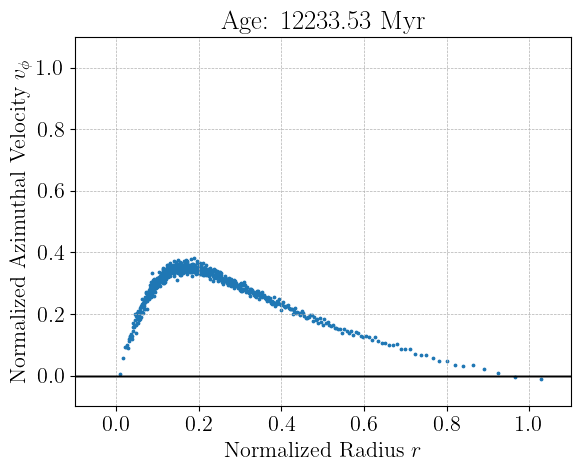

In [ ]:
# Create animation of azimuthal velocity vs radius
num_snapshots = r.shape[0]
fig, ax = plt.subplots()
scat = ax.scatter([], [], s=3)  # Empty scatter plot for animation

def init():
    """Initialize the animation with empty data and set up axes"""
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel('Normalized Azimuthal Velocity $v_\\phi$')
    ax.set_xlabel('Normalized Radius $r$')
    ax.axhline(0, color='black', lw=1)  # Add horizontal line at y=0
    ax.grid(True, which='both', ls='--', lw=0.5)
    return scat,

def update(frame):
    """Update function for animation - plots data for each time frame"""
    xdata = r[frame]
    ydata = v_phi[frame]
    # Remove points where either x or y is zero (invalid data points)
    indices = np.where((xdata == 0) | (ydata == 0))
    xdata = np.delete(xdata, indices)
    ydata = np.delete(ydata, indices)
    scat.set_offsets(np.c_[xdata, ydata])
    ax.set_title(f'Age: {age[frame]:.2f} Myr')
    return scat,

# Create and save the animation
anim = FuncAnimation(fig, update, frames=np.linspace(0, num_snapshots-1, num_snapshots).astype(int),
                    init_func=init, blit=True, interval=150)
anim.save(os.path.join(save_path, f'{models[model_index].split('_')[0]}_v_phi.gif'), writer="Pillow")

# Animation: Log-Scale Visualization

Create an animated scatter plot similar to the previous one, but with a logarithmic scale for the radius.
This visualization helps to better observe the behavior in the inner regions of the GC where:
1. The density of points is higher
2. The velocity gradients are steeper
3. The dynamical evolution is more rapid

MovieWriter Pillow unavailable; using Pillow instead.


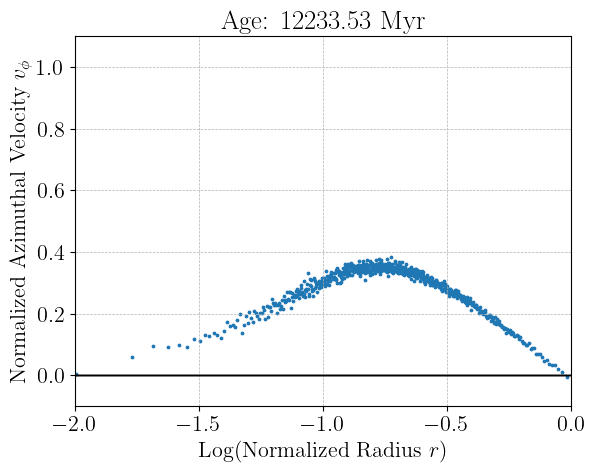

In [ ]:
# Create animation of azimuthal velocity vs log-radius
num_snapshots = r.shape[0]
fig, ax = plt.subplots()
scat = ax.scatter([], [], s=3)  # Empty scatter plot for animation

def init():
    """Initialize the animation with empty data and set up axes"""
    ax.set_xlim(-2, 0)  # Log scale limits
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel('Normalized Azimuthal Velocity $v_\\phi$')
    ax.set_xlabel('Log(Normalized Radius $r$)')
    ax.axhline(0, color='black', lw=1)  # Add horizontal line at y=0
    ax.grid(True, which='both', ls='--', lw=0.5)
    return scat,

def update(frame):
    """Update function for animation - plots data for each time frame with log-scaled radius"""
    xdata = r[frame]
    ydata = v_phi[frame]
    # Remove points where either x or y is zero (invalid data points)
    indices = np.where((xdata == 0) | (ydata == 0))
    xdata = np.delete(xdata, indices)
    ydata = np.delete(ydata, indices)
    # Convert radius to log scale
    scat.set_offsets(np.c_[np.log10(xdata), ydata])
    ax.set_title(f'Age: {age[frame]:.2f} Myr')
    return scat,

# Create and save the animation
anim = FuncAnimation(fig, update, frames=np.linspace(0, num_snapshots-1, num_snapshots).astype(int),
                    init_func=init, blit=True, interval=150)
anim.save(os.path.join(save_path, f'{models[model_index].split('_')[0]}_v_phi_rlog10.gif'), writer="Pillow")

# Animation: Velocity Dispersion Profile

Create an animated visualization of the velocity dispersion ($\sigma_\phi$) profile:
1. Shows the evolution of velocity dispersion as a function of radius
2. Helps understand the heating/cooling processes in the GC
3. Reveals the dynamical state of different GC regions
4. Tracks changes in orbital structure over time

MovieWriter Pillow unavailable; using Pillow instead.


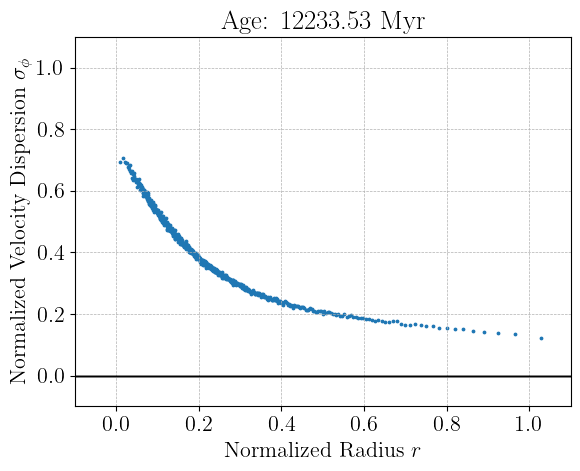

In [ ]:
# Create animation of velocity dispersion vs radius
num_snapshots = r.shape[0]
fig, ax = plt.subplots()
scat = ax.scatter([], [], s=3)  # Empty scatter plot for animation

def init():
    """Initialize the animation with empty data and set up axes"""
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel('Normalized Velocity Dispersion $\\sigma_\\phi$')
    ax.set_xlabel('Normalized Radius $r$')
    ax.axhline(0, color='black', lw=1)  # Add horizontal line at y=0
    ax.grid(True, which='both', ls='--', lw=0.5)
    return scat,

def update(frame):
    """Update function for animation - plots velocity dispersion data for each time frame"""
    xdata = r[frame]
    ydata = s_phi[frame]  # Using s_phi (velocity dispersion) instead of v_phi
    # Remove points where either x or y is zero (invalid data points)
    indices = np.where((xdata == 0) | (ydata == 0))
    xdata = np.delete(xdata, indices)
    ydata = np.delete(ydata, indices)
    scat.set_offsets(np.c_[xdata, ydata])
    ax.set_title(f'Age: {age[frame]:.2f} Myr')
    return scat,

# Create and save the animation
anim = FuncAnimation(fig, update, frames=np.linspace(0, num_snapshots-1, num_snapshots).astype(int),
                    init_func=init, blit=True, interval=150)
anim.save(os.path.join(save_path, f'{models[model_index].split('_')[0]}_s_phi.gif'), writer="Pillow")

# Animation: Velocity Dispersion Profile (Log-Scale)

Create an animated visualization of the velocity dispersion ($\sigma_\phi$) profile with logarithmic radius scaling:
1. Uses log10 scale for radius to better visualize inner regions
2. Shows the evolution of velocity dispersion over time
3. Helps identify characteristic scales in the dispersion profile
4. Complements the linear-scale dispersion animation

MovieWriter Pillow unavailable; using Pillow instead.


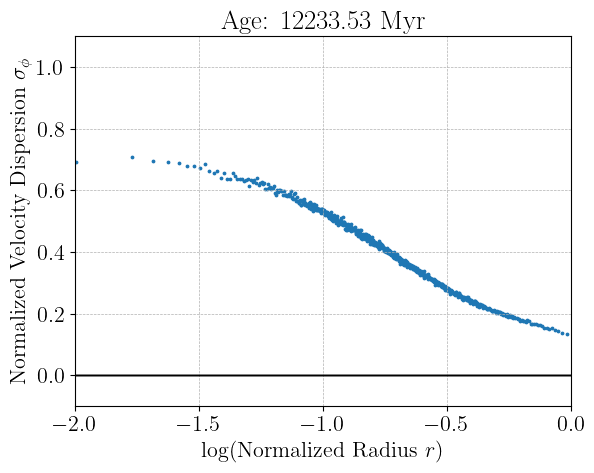

In [9]:
# make an animation of v_phi vs r for different snapshots
num_snapshots = r.shape[0]
fig, ax = plt.subplots()
scat = ax.scatter([], [], s=3)
def init():
    ax.set_xlim(-2, 0)
    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel('Normalized Velocity Dispersion $\\sigma_\\phi$')
    ax.set_xlabel('log(Normalized Radius $r$)')
    ax.axhline(0, color='black', lw=1)
    ax.grid(True, which='both', ls='--', lw=0.5)
    return scat,

def update(frame):
    xdata = r[frame]
    ydata = s_phi[frame]
    indices = np.where((xdata == 0) | (ydata == 0))
    xdata = np.delete(xdata, indices)
    ydata = np.delete(ydata, indices)
    scat.set_offsets(np.c_[np.log10(xdata), ydata])
    ax.set_title(f'Age: {age[frame]:.2f} Myr')
    return scat,

anim = FuncAnimation(fig, update, frames=np.linspace(0, num_snapshots-1, num_snapshots).astype(int),
                    init_func=init, blit=True, interval=150)
anim.save(os.path.join(save_path, f'{models[model_index].split('_')[0]}_s_phi_rlog10.gif'), writer="Pillow")


# Data Selection for Model Fitting

Prepare data for symbolic regression analysis:
1. Load data for a specific model
2. Select time snapshots with specific criteria:
   - Regular sampling (every 100 steps)
   - Starting from t = 1750 for most models
   - Special handling for models 12 and 13 (start from age = 4000 Myr)
3. Normalize the selected data for consistent fitting

In [ ]:
# Load data for model fitting
model_data = load_model_data_radial(models[model_index], data_path)
r = model_data['r']
v_phi = model_data['v_phi']
s_phi = model_data['disp_phi']
age = model_data['age']

# Select specific time snapshots for analysis
# For most models: start from t=1750
selected_indices = np.array(range(1750, len(age), 100))
# Special handling for models 12 and 13: start from age=4000 Myr
if model_index == 12 or model_index == 13:
    start = np.argmin(np.abs(age-4000))  # Find closest index to age 4000
    selected_indices = np.array(range(start, len(age), 100))    

# Extract selected data points
r_selec = r[selected_indices,:]
v_phi_selec = v_phi[selected_indices,:]
s_phi_selec = s_phi[selected_indices,:]
age_selec = age[selected_indices]

# Normalize selected data by their maximum values
# This helps in comparing different models and improves numerical stability
r_selec /= np.nanmax(r_selec)
v_phi_selec /= np.nanmax(v_phi_selec)
s_phi_selec /= np.nanmax(s_phi_selec)

# Symbolic Expression Plotting Utility

Define a utility function for plotting symbolic regression results:
1. Converts PhySO expressions to SymPy format
2. Creates LaTeX representation of equations
3. Evaluates expressions with fitted constants
4. Generates labels with equation and parameter values
5. Returns evaluated y values and formatted labels for plotting

In [ ]:
def plot_data(best_expr, x, index=0):
    """
    Plot symbolic regression results with equations and parameters.
    
    Parameters:
        best_expr: PhySO expression object
        x: Array of x values for evaluation
        index: Index of the realization to plot (default=0)
    
    Returns:
        tuple: (y_values, label_text)
            - y_values: Evaluated expression values
            - label_text: Formatted string with equation and parameters
    """
    # Get the symbolic expression and create LaTeX representation
    sympy_expr = best_expr.get_infix_sympy(evaluate_consts=True)[index]
    label = "Curr Eq: $"+best_expr.get_infix_latex(do_simplify=True)+"$" + '\n\n'
    
    # Get dictionary of constants and their values
    sympy_local_dicts = best_expr.get_sympy_local_dicts(replace_nan_with=False)
    constants = list(sympy_local_dicts[index].keys())
    
    # Format constants and their values for display
    for i in range(len(constants)):
        const_name = constants[i]
        const_value = sympy_local_dicts[index][const_name]
        label += f' ${const_name}$={const_value:.3f}'
        if i%2==1:
            label += '\n'

    # Convert symbolic expression to numerical function and evaluate
    variables = list(sympy_expr.free_symbols)
    f = lambdify(variables, sympy_expr, 'numpy')
    y = f(x)
    
    return y, label

# Visualization of Model Equations

Create an animated visualization comparing different symbolic regression models:
1. Load Pareto-optimal expressions from saved results
2. Plot data points vs. fitted curves
3. Display the mathematical expression and fitted parameters
4. Animate through different equations in the Pareto front
5. Save the animation as a GIF for comparison

MovieWriter Pillow unavailable; using Pillow instead.
<lambdifygenerated-3>:2: RuntimeWarning: divide by zero encountered in divide
  return 0.614308471300631 - 0.00211721127972488/r
<lambdifygenerated-3>:2: RuntimeWarning: divide by zero encountered in divide
  return 0.614308471300631 - 0.00211721127972488/r
<lambdifygenerated-6>:2: RuntimeWarning: invalid value encountered in sqrt
  return 0.974125189378992*(-r/(r + 0.0127964700381252) + 0.505352553064734)**0.5
<lambdifygenerated-7>:2: RuntimeWarning: divide by zero encountered in divide
  return 0.65941377536318*exp(-0.00989782572602918/r)
<lambdifygenerated-6>:2: RuntimeWarning: invalid value encountered in sqrt
  return 0.974125189378992*(-r/(r + 0.0127964700381252) + 0.505352553064734)**0.5
<lambdifygenerated-7>:2: RuntimeWarning: divide by zero encountered in divide
  return 0.65941377536318*exp(-0.00989782572602918/r)


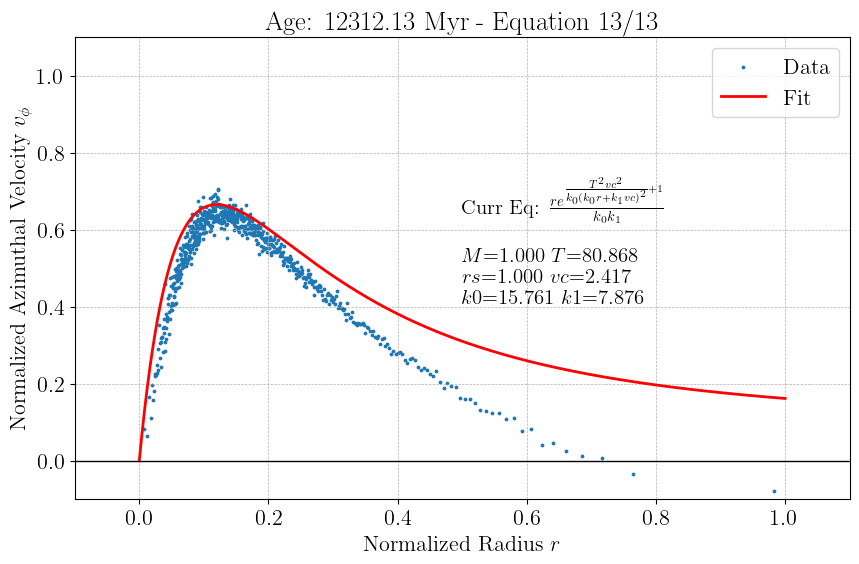

In [ ]:
# Load Pareto-optimal expressions from symbolic regression
pareto_expressions = physo.read_pareto_pkl(model_path[trial_number-1])
num_eqs = len(pareto_expressions)-1  # Number of equations in Pareto front
sympy.init_printing()  # Initialize pretty printing for sympy

# Set up the figure for animation
fig, ax = plt.subplots(figsize=(10, 6))
scat = ax.scatter(r_selec[-1], v_phi_selec[-1], s=3, label='Data')  # Plot data points
line, = ax.plot([], [], color='red', linewidth=2, label='Fit')  # Empty line for fitted curve

# Configure plot layout
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel('Normalized Azimuthal Velocity $v_\\phi$')
ax.set_xlabel('Normalized Radius $r$')
ax.axhline(0, color='black', lw=1)
ax.grid(True, which='both', ls='--', lw=0.5)
ax.legend()

# Add text box for equation display
text = ax.text(0.5, 0.7, '', transform=ax.transAxes, verticalalignment='top', fontsize=15)

def init():
    """Initialize animation with empty plots"""
    line.set_data([], [])
    text.set_text('')
    return line, text

def update(frame):
    """Update animation frame - show different equations from Pareto front"""
    x = np.linspace(0, 1, 1000)  # Generate x values for smooth curve
    # Get y values and equation label for current Pareto optimal solution
    y, label = plot_data(pareto_expressions[frame+1], x, index=-1)
    line.set_data(x, y)
    text.set_text(label)
    ax.set_title(f'Age: {age_selec[-1]:.2f} Myr - Equation {frame+1}/{num_eqs}')
    return line, text

# Create and save animation
anim = FuncAnimation(fig, update, frames=num_eqs, init_func=init, blit=True, interval=750)
anim.save(os.path.join(save_path, f'{models[model_index].split('_')[0]}_v_phi_fit.gif'), writer="Pillow")

# Time Evolution Animation

Create an animation showing how the best-fit model evolves over time:
1. Use the best model from the Pareto front
2. Animate through different time snapshots
3. Show both data points and fitted curve for each time step
4. Display current equation and parameters
5. Track the age progression through the simulation

MovieWriter Pillow unavailable; using Pillow instead.


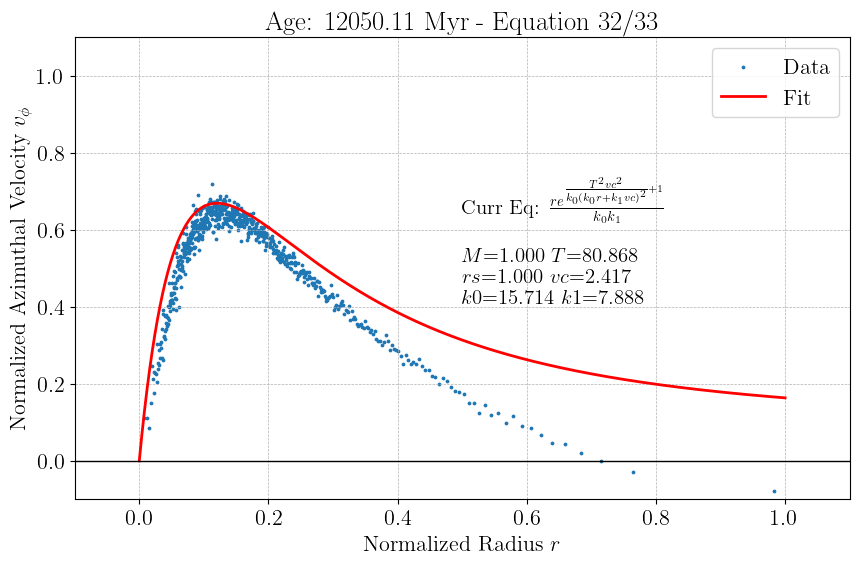

In [13]:
pareto_expressions = physo.read_pareto_pkl(model_path[trial_number-1])
num_snapshots = len(pareto_expressions[-1].get_sympy_local_dicts(replace_nan_with=False))
sympy.init_printing()

fig, ax = plt.subplots(figsize=(10, 6))
scat = ax.scatter(r_selec[0], v_phi_selec[0], s=3, label='Data')
line, = ax.plot([], [], color='red', linewidth=2, label='Fit')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel('Normalized Azimuthal Velocity $v_\\phi$')
ax.set_xlabel('Normalized Radius $r$')
ax.axhline(0, color='black', lw=1)
ax.grid(True, which='both', ls='--', lw=0.5)
ax.legend()
text = ax.text(0.5, 0.7, '', transform=ax.transAxes, verticalalignment='top', fontsize=15)

def init():
    line.set_data([], [])
    text.set_text('')
    return line, text

def update(frame):
    x = np.linspace(0, 1, 1000)
    y, label = plot_data(pareto_expressions[-1], x, index=frame)
    scat.set_offsets(np.c_[r_selec[frame], v_phi_selec[frame]])
    line.set_data(x, y)
    text.set_text(label)
    ax.set_title(f'Age: {age_selec[frame]:.2f} Myr - Equation {frame+1}/{num_snapshots}')
    return line, text

anim = FuncAnimation(fig, update, frames=num_snapshots-1, init_func=init, blit=True, interval=750)
anim.save(os.path.join(save_path, f'{models[model_index].split('_')[0]}_v_phi_timeEvo.gif'), writer="Pillow")


## TRIAL 9 ONLY (maybe 8 with some tweaks)

In [ ]:
# Modified plot_data function for trials 8 and 9
# These trials had special handling requirements for constant names
def plot_data(best_expr, x, index=0):
    """
    Plot symbolic regression results with special handling for trials 8 and 9.
    Handles issues with constant names containing '$' and '^' characters.
    
    Parameters:
        best_expr: PhySO expression object
        x: Array of x values for evaluation
        index: Index of the realization to plot (default=0)
    
    Returns:
        tuple: (y_values, label_text)
            - y_values: Evaluated expression values
            - label_text: Formatted string with equation and parameters
    """
    # Get the raw program string and clean it
    program_str = best_expr.get_infix_str()
    program_str = program_str.replace('$', '')
    
    # Parse string to SymPy expression
    program_sympy = sympy.parsing.sympy_parser.parse_expr(program_str, evaluate=False)
    sympy_expr_latex = sympy.latex(program_sympy)
    
    # Get and clean up constant dictionaries
    sympy_local_dicts = best_expr.get_sympy_local_dicts(replace_nan_with=False)
    for i in range(len(sympy_local_dicts)):
        for key in list(sympy_local_dicts[i].keys()):
            if '$' in key:
                # Remove '$' from constant names
                new_key = key.replace('$', '')
                sympy_local_dicts[i][new_key] = sympy_local_dicts[i].pop(key)
            if '^' in key:
                # Replace 'mt^{-1}' with 'gamma'
                new_key = key.replace('mt^{-1}', 'gamma')
                sympy_local_dicts[i][new_key] = sympy_local_dicts[i].pop(key.replace('$', ''))
    
    # Generate expressions for all realizations
    sympy_exprs = [program_sympy.subs(sympy_local_dicts[i_real]) 
                   for i_real in range(best_expr.n_realizations)]
    sympy_expr = sympy_exprs[index]
    
    # Create label with equation and parameters
    label = "Curr Eq: $"+sympy_expr_latex+"$" + '\n\n'
    constants = list(sympy_local_dicts[index].keys())
    for i in range(len(constants)):
        const_name = constants[i].replace('$', '')
        const_name = const_name.replace('mt^{-1}', '$ \\gamma $')
        const_value = sympy_local_dicts[index][constants[i]]
        label += f' ${const_name}$={const_value:.3f}'
        if i%2==1:
            label += '\n'

    # Evaluate expression
    variables = list(sympy_expr.free_symbols)
    f = lambdify(variables, sympy_expr, 'numpy')
    y = f(x)
    
    return y, label

MovieWriter Pillow unavailable; using Pillow instead.


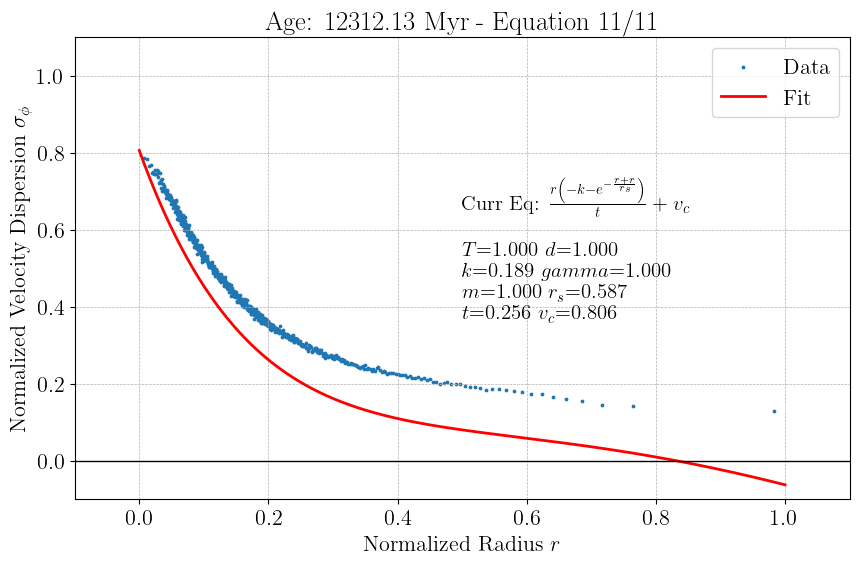

In [ ]:
pareto_expressions = physo.read_pareto_pkl(model_path[trial_number-1])
num_eqs = len(pareto_expressions)-1
sympy.init_printing()

fig, ax = plt.subplots(figsize=(10, 6))
scat = ax.scatter(r_selec[-1], s_phi_selec[-1], s=3, label='Data')
line, = ax.plot([], [], color='red', linewidth=2, label='Fit')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel('Normalized Velocity Dispersion $\\sigma_\\phi$')
ax.set_xlabel('Normalized Radius $r$')
ax.axhline(0, color='black', lw=1)
ax.grid(True, which='both', ls='--', lw=0.5)
ax.legend()
text = ax.text(0.5, 0.7, '', transform=ax.transAxes, verticalalignment='top', fontsize=15)

def init():
    line.set_data([], [])
    text.set_text('')
    return line, text

def update(frame):
    x = np.linspace(0, 1, 1000)
    y, label = plot_data(pareto_expressions[frame+1], x, index=-1)
    line.set_data(x, y)
    text.set_text(label)
    ax.set_title(f'Age: {age_selec[-1]:.2f} Myr - Equation {frame+1}/{num_eqs}')
    return line, text

anim = FuncAnimation(fig, update, frames=num_eqs, init_func=init, blit=True, interval=750)
anim.save(os.path.join(save_path, f'{models[model_index].split('_')[0]}_v_phi_fit.gif'), writer="Pillow")

MovieWriter Pillow unavailable; using Pillow instead.


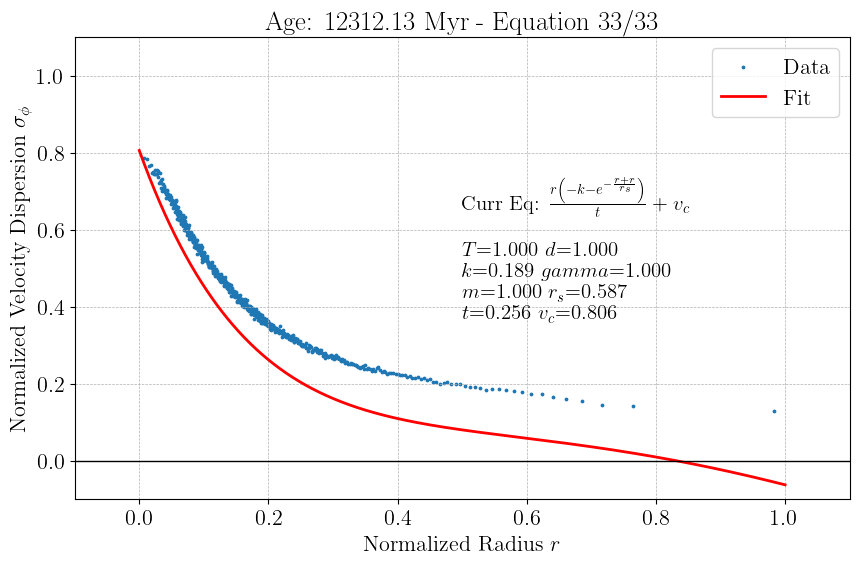

In [ ]:
pareto_expressions = physo.read_pareto_pkl(model_path[trial_number-1])
num_snapshots = len(pareto_expressions[-1].get_sympy_local_dicts(replace_nan_with=False))
sympy.init_printing()

fig, ax = plt.subplots(figsize=(10, 6))
scat = ax.scatter(r_selec[0], s_phi_selec[0], s=3, label='Data')
line, = ax.plot([], [], color='red', linewidth=2, label='Fit')
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel('Normalized Velocity Dispersion $\\sigma_\\phi$')
ax.set_xlabel('Normalized Radius $r$')
ax.axhline(0, color='black', lw=1)
ax.grid(True, which='both', ls='--', lw=0.5)
ax.legend()
text = ax.text(0.5, 0.7, '', transform=ax.transAxes, verticalalignment='top', fontsize=15)

def init():
    line.set_data([], [])
    text.set_text('')
    return line, text

def update(frame):
    x = np.linspace(0, 1, 1000)
    y, label = plot_data(pareto_expressions[-1], x, index=frame)
    scat.set_offsets(np.c_[r_selec[frame], s_phi_selec[frame]])
    line.set_data(x, y)
    text.set_text(label)
    ax.set_title(f'Age: {age_selec[frame]:.2f} Myr - Equation {frame+1}/{num_snapshots}')
    return line, text
anim = FuncAnimation(fig, update, frames=num_snapshots, init_func=init, blit=True, interval=750)
anim.save(os.path.join(save_path, f'{models[model_index].split('_')[0]}_v_phi_timeEvo.gif'), writer="Pillow")
